In [1]:
import pandas as pd
from PIL import Image
import torch.nn as nn
import io
from transformers import BertTokenizer, BertModel
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
# Input data files are available in the read-only "../input/" directory
import pandas as pd
from PIL import Image
import io
import ast  # this is 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pokemon/train-00000-of-00001-a1df3b486d3a28b0.parquet
/kaggle/input/pokemon-llava-images-and-text-descriptions/train.csv


In [2]:
pokemon_list = [
    "Bulbasaur", "Ivysaur", "Venusaur",
    "Charmander", "Charmeleon", "Charizard",
    "Squirtle", "Wartortle", "Blastoise",
    "Caterpie", "Metapod", "Butterfree",
    "Weedle", "Kakuna", "Beedrill",
    "Pidgey", "Pidgeotto", "Pidgeot",
    "Rattata", "Raticate", "Spearow",
    "Fearow", "Ekans", "Arbok",
    "Pikachu", "Raichu", "Sandshrew",
    "Sandslash", "Nidoran♀", "Nidorina",
    "Nidoqueen", "Nidoran♂", "Nidorino",
    "Nidoking", "Clefairy", "Clefable",
    "Vulpix", "Ninetales", "Jigglypuff",
    "Wigglytuff", "Zubat", "Golbat",
    "Oddish", "Gloom", "Vileplume",
    "Paras", "Parasect", "Venonat",
    "Venomoth", "Diglett", "Dugtrio",
    "Meowth", "Persian", "Psyduck",
    "Golduck", "Mankey", "Primeape",
    "Growlithe", "Arcanine", "Poliwag",
    "Poliwhirl", "Poliwrath", "Abra",
    "Kadabra", "Alakazam", "Machop",
    "Machoke", "Machamp", "Bellsprout",
    "Weepinbell", "Victreebel", "Tentacool",
    "Tentacruel", "Geodude", "Graveler",
    "Golem", "Ponyta", "Rapidash",
    "Slowpoke", "Slowbro", "Magnemite",
    "Magneton", "Farfetch'd", "Doduo",
    "Dodrio", "Seel", "Dewgong",
    "Grimer", "Muk", "Shellder",
    "Cloyster", "Gastly", "Haunter",
    "Gengar", "Onix", "Drowzee",
    "Hypno", "Krabby", "Kingler",
    "Voltorb", "Electrode", "Exeggcute",
    "Exeggutor", "Cubone", "Marowak",
    "Hitmonlee", "Hitmonchan", "Lickitung",
    "Koffing", "Weezing", "Rhyhorn",
    "Rhydon", "Chansey", "Tangela",
    "Kangaskhan", "Horsea", "Seadra",
    "Goldeen", "Seaking", "Staryu",
    "Starmie", "Mr. Mime", "Scyther",
    "Jynx", "Electabuzz", "Magmar",
    "Pinsir", "Tauros", "Magikarp",
    "Gyarados", "Lapras", "Ditto",
    "Eevee", "Vaporeon", "Jolteon",
    "Flareon", "Porygon", "Omanyte",
    "Omastar", "Kabuto", "Kabutops",
    "Aerodactyl", "Snorlax", "Articuno",
    "Zapdos", "Moltres", "Dratini",
    "Dragonair", "Dragonite", "Mewtwo",
    "Mew", "Chikorita", "Bayleef",
    "Meganium", "Cyndaquil", "Quilava",
    "Typhlosion", "Totodile", "Croconaw",
    "Feraligatr", "Sentret", "Furret",
    "Hoothoot", "Noctowl", "Ledyba",
    "Ledian", "Spinarak", "Ariados",
    "Crobat", "Chinchou", "Lanturn",
    "Pichu", "Cleffa", "Igglybuff",
    "Togepi", "Togetic", "Natu",
    "Xatu", "Mareep", "Flaaffy",
    "Ampharos", "Bellossom", "Marill",
    "Azumarill", "Sudowoodo", "Politoed",
    "Hoppip", "Skiploom", "Jumpluff",
    "Aipom", "Sunkern", "Sunflora",
    "Yanma", "Wooper", "Quagsire",
    "Espeon", "Umbreon", "Murkrow",
    "Slowking", "Misdreavus", "Unown",
    "Wobbuffet", "Girafarig", "Pineco",
    "Forretress", "Dunsparce", "Gligar",
    "Steelix", "Snubbull", "Granbull",
    "Qwilfish", "Scizor", "Shuckle",
    "Heracross", "Sneasel", "Teddiursa",
    "Ursaring", "Slugma", "Magcargo",
    "Swinub", "Piloswine", "Corsola",
    "Remoraid", "Octillery", "Delibird",
    "Mantine", "Skarmory", "Houndour",
    "Houndoom", "Kingdra", "Phanpy",
    "Donphan", "Porygon2", "Stantler",
    "Smeargle", "Tyrogue", "Hitmontop",
    "Smoochum", "Elekid", "Magby",
    "Miltank", "Blissey", "Raikou",
    "Entei", "Suicune", "Larvitar",
    "Pupitar", "Tyranitar", "Lugia",
    "Ho-Oh", "Celebi", "Treecko",
    "Grovyle", "Sceptile", "Torchic",
    "Combusken", "Blaziken", "Mudkip",
    "Marshtomp", "Swampert", "Poochyena",
    "Mightyena", "Zigzagoon", "Linoone",
    "Wurmple", "Silcoon", "Beautifly",
    "Cascoon", "Dustox", "Lotad",
    "Lombre", "Ludicolo", "Seedot",
    "Nuzleaf", "Shiftry", "Taillow",
    "Swellow", "Wingull", "Pelipper",
    "Ralts", "Kirlia", "Gardevoir",
    "Surskit", "Masquerain", "Shroomish",
    "Breloom", "Slakoth", "Vigoroth",
    "Slaking", "Nincada", "Ninjask",
    "Shedinja", "Whismur", "Loudred",
    "Exploud", "Makuhita", "Hariyama",
    "Azurill", "Nosepass", "Skitty",
    "Delcatty", "Sableye", "Mawile",
    "Aron", "Lairon", "Aggron",
    "Meditite", "Medicham", "Electrike",
    "Manectric", "Plusle", "Minun",
    "Volbeat", "Illumise", "Roselia",
    "Gulpin", "Swalot", "Carvanha",
    "Sharpedo", "Wailmer", "Wailord",
    "Numel", "Camerupt", "Torkoal",
    "Spoink", "Grumpig", "Spinda",
    "Trapinch", "Vibrava", "Flygon",
    "Cacnea", "Cacturne", "Swablu",
    "Altaria", "Zangoose", "Seviper",
    "Lunatone", "Solrock", "Barboach",
    "Whiscash", "Corphish", "Crawdaunt",
    "Baltoy", "Claydol", "Lileep",
    "Cradily", "Anorith", "Armaldo",
    "Feebas", "Milotic", "Castform",
    "Kecleon", "Shuppet", "Banette",
    "Duskull", "Dusclops", "Tropius",
    "Chimecho", "Absol", "Wynaut",
    "Snorunt", "Glalie", "Spheal",
    "Sealeo", "Walrein", "Clamperl",
    "Huntail", "Gorebyss", "Relicanth",
    "Luvdisc", "Bagon", "Shelgon",
    "Salamence", "Beldum", "Metang",
    "Metagross", "Regirock", "Regice",
    "Registeel", "Latias", "Latios",
    "Kyogre", "Groudon", "Rayquaza",
    "Jirachi", "Deoxys", "Turtwig",
    "Grotle", "Torterra", "Chimchar",
    "Monferno", "Infernape", "Piplup",
    "Prinplup", "Empoleon", "Starly",
    "Staravia", "Staraptor", "Bidoof",
    "Bibarel", "Kricketot", "Kricketune",
    "Shinx", "Luxio", "Luxray",
    "Budew", "Roserade", "Cranidos",
    "Rampardos", "Shieldon", "Bastiodon",
    "Burmy", "Wormadam", "Mothim",
    "Combee", "Vespiquen", "Pachirisu",
    "Buizel", "Floatzel", "Cherubi",
    "Cherrim", "Shellos", "Gastrodon",
    "Ambipom", "Drifloon", "Drifblim",
    "Buneary", "Lopunny", "Mismagius",
    "Honchkrow", "Glameow", "Purugly",
    "Chingling", "Stunky", "Skuntank",
    "Bronzor", "Bronzong", "Bonsly",
    "Mime Jr.", "Happiny", "Chatot",
    "Spiritomb", "Gible", "Gabite",
    "Garchomp", "Munchlax", "Riolu",
    "Lucario", "Hippopotas", "Hippowdon",
    "Skorupi", "Drapion", "Croagunk",
    "Toxicroak", "Carnivine", "Finneon",
    "Lumineon", "Mantyke", "Snover",
    "Abomasnow", "Weavile", "Magnezone",
    "Lickilicky", "Rhyperior", "Tangrowth",
    "Electivire", "Magmortar", "Togekiss",
    "Yanmega", "Leafeon", "Glaceon",
    "Gliscor", "Mamoswine", "Porygon-Z",
    "Gallade", "Probopass", "Dusknoir",
    "Froslass", "Rotom", "Uxie",
    "Mesprit", "Azelf", "Dialga",
    "Palkia", "Heatran", "Regigigas",
    "Giratina", "Cresselia", "Phione",
    "Manaphy", "Darkrai", "Shaymin",
    "Arceus", "Victini", "Snivy",
    "Servine", "Serperior", "Tepig",
    "Pignite", "Emboar", "Oshawott",
    "Dewott", "Samurott", "Patrat",
    "Watchog", "Lillipup", "Herdier",
    "Stoutland", "Purrloin", "Liepard",
    "Pansage", "Simisage", "Pansear",
    "Simisear", "Panpour", "Simipour",
    "Munna", "Musharna", "Pidove",
    "Tranquill", "Unfezant", "Blitzle",
    "Zebstrika", "Roggenrola", "Boldore",
    "Gigalith", "Woobat", "Swoobat",
    "Drilbur", "Excadrill", "Audino",
    "Timburr", "Gurdurr", "Conkeldurr",
    "Tympole", "Palpitoad", "Seismitoad",
    "Throh", "Sawk", "Sewaddle",
    "Swadloon", "Leavanny", "Venipede",
    "Whirlipede", "Scolipede", "Cottonee",
    "Whimsicott", "Petilil", "Lilligant",
    "Basculin", "Sandile", "Krokorok",
    "Krookodile", "Darumaka", "Darmanitan",
    "Maractus", "Dwebble", "Crustle",
    "Scraggy", "Scrafty", "Sigilyph",
    "Yamask", "Cofagrigus", "Tirtouga",
    "Carracosta", "Archen", "Archeops",
    "Trubbish", "Garbodor", "Zorua",
    "Zoroark", "Minccino", "Cinccino",
    "Gothita", "Gothorita", "Gothitelle",
    "Solosis", "Duosion", "Reuniclus",
    "Ducklett", "Swanna", "Vanillite",
    "Vanillish", "Vanilluxe", "Deerling",
    "Sawsbuck", "Emolga", "Karrablast",
    "Escavalier", "Foongus", "Amoonguss",
    "Frillish", "Jellicent", "Alomomola",
    "Joltik", "Galvantula", "Ferroseed",
    "Ferrothorn", "Klink", "Klang",
    "Klinklang", "Tynamo", "Eelektrik",
    "Eelektross", "Elgyem", "Beheeyem",
    "Litwick", "Lampent", "Chandelure",
    "Axew", "Fraxure", "Haxorus",
    "Cubchoo", "Beartic", "Cryogonal",
    "Shelmet", "Accelgor", "Stunfisk",
    "Mienfoo", "Mienshao", "Druddigon",
    "Golett", "Golurk", "Pawniard",
    "Bisharp", "Bouffalant", "Rufflet",
    "Braviary", "Vullaby", "Mandibuzz",
    "Heatmor", "Durant", "Deino",
    "Zweilous", "Hydreigon", "Larvesta",
    "Volcarona", "Cobalion", "Terrakion",
    "Virizion", "Tornadus", "Thundurus",
    "Reshiram", "Zekrom", "Landorus",
    "Kyurem", "Keldeo", "Meloetta",
    "Genesect", "Chespin", "Quilladin",
    "Chesnaught", "Fennekin", "Braixen",
    "Delphox", "Froakie", "Frogadier",
    "Greninja", "Bunnelby", "Diggersby",
    "Fletchling", "Fletchinder", "Talonflame",
    "Scatterbug", "Spewpa", "Vivillon",
    "Litleo", "Pyroar", "Flabébé",
    "Floette", "Florges", "Skiddo",
    "Gogoat", "Pancham", "Pangoro",
    "Furfrou", "Espurr", "Meowstic",
    "Honedge", "Doublade", "Aegislash",
    "Spritzee", "Aromatisse", "Swirlix",
    "Slurpuff", "Inkay", "Malamar",
    "Binacle", "Barbaracle", "Skrelp",
    "Dragalge", "Clauncher", "Clawitzer",
    "Helioptile", "Heliolisk", "Tyrunt",
    "Tyrantrum", "Amaura", "Aurorus",
    "Sylveon", "Hawlucha", "Dedenne",
    "Carbink", "Goomy", "Sliggoo",
    "Goodra", "Klefki", "Phantump",
    "Trevenant", "Pumpkaboo", "Gourgeist",
    "Bergmite", "Avalugg", "Noibat",
    "Noivern", "Xerneas", "Yveltal",
    "Zygarde", "Diancie", "Hoopa",
    "Volcanion", "Rowlet", "Dartrix",
    "Decidueye", "Litten", "Torracat",
    "Incineroar", "Popplio", "Brionne",
    "Primarina", "Pikipek", "Trumbeak",
    "Toucannon", "Yungoos", "Gumshoos",
    "Grubbin", "Charjabug", "Vikavolt",
    "Crabrawler", "Crabominable", "Oricorio",
    "Cutiefly", "Ribombee", "Rockruff",
    "Lycanroc", "Wishiwashi", "Mareanie",
    "Toxapex", "Mudbray", "Mudsdale",
    "Dewpider", "Araquanid", "Fomantis",
    "Lurantis", "Morelull", "Shiinotic",
    "Salandit", "Salazzle", "Stufful",
    "Bewear", "Bounsweet", "Steenee",
    "Tsareena", "Comfey", "Oranguru",
    "Passimian", "Wimpod", "Golisopod",
    "Sandygast", "Palossand", "Pyukumuku",
    "Type: Null", "Silvally", "Minior",
    "Komala", "Turtonator", "Togedemaru",
    "Mimikyu", "Bruxish", "Drampa",
    "Dhelmise", "Jangmo-o", "Hakamo-o",
    "Kommo-o", "Tapu Koko", "Tapu Lele",
    "Tapu Bulu", "Tapu Fini", "Cosmog",
    "Cosmoem", "Solgaleo", "Lunala",
    "Nihilego", "Buzzwole", "Pheromosa",
    "Xurkitree", "Celesteela", "Kartana",
    "Guzzlord", "Necrozma", "Magearna",
    "Marshadow", "Poipole", "Naganadel",
    "Stakataka", "Blacephalon", "Zeraora",
    "Meltan", "Melmetal", "Grookey",
    "Thwackey", "Rillaboom", "Scorbunny",
    "Raboot", "Cinderace", "Sobble",
    "Drizzile", "Inteleon", "Skwovet",
    "Greedent", "Rookidee", "Corvisquire",
    "Corviknight", "Blipbug", "Dottler",
    "Orbeetle", "Nickit", "Thievul",
    "Gossifleur", "Eldegoss", "Wooloo",
    "Dubwool", "Chewtle", "Drednaw",
    "Yamper", "Boltund", "Rolycoly",
    "Carkol", "Coalossal", "Applin",
    "Flapple", "Appletun", "Silicobra",
    "Sandaconda", "Cramorant", "Arrokuda",
    "Barraskewda", "Toxel", "Toxtricity",
    "Sizzlipede", "Centiskorch", "Clobbopus",
    "Grapploct", "Sinistea", "Polteageist",
    "Hatenna", "Hattrem", "Hatterene",
    "Impidimp", "Morgrem", "Grimmsnarl",
    "Obstagoon", "Perrserker", "Cursola",
    "Sirfetch'd", "Mr. Rime", "Runerigus",
    "Milcery", "Alcremie", "Falinks",
    "Pincurchin", "Snom", "Frosmoth",
    "Stonjourner", "Eiscue", "Indeedee",
    "Morpeko", "Cufant", "Copperajah",
    "Dracozolt", "Arctozolt", "Dracovish",
    "Arctovish", "Duraludon", "Dreepy",
    "Drakloak", "Dragapult", "Zacian",
    "Zamazenta", "Eternatus", "Kubfu",
    "Urshifu", "Zarude", "Regieleki",
    "Regidrago", "Glastrier", "Spectrier",
    "Calyrex", "Wyrdeer", "Kleavor",
    "Ursaluna", "Basculegion", "Sneasler",
    "Overqwil", "Enamorus", "Sprigatito",
    "Floragato", "Meowscarada", "Fuecoco",
    "Crocalor", "Skeledirge", "Quaxly",
    "Quaxwell", "Quaquaval", "Lechonk",
    "Oinkologne", "Tarountula", "Spidops",
    "Nymble", "Lokix", "Pawmi",
    "Pawmo", "Pawmot", "Tandemaus",
    "Maushold", "Fidough", "Dachsbun",
    "Smoliv", "Dolliv", "Arboliva",
    "Squawkabilly", "Nacli", "Naclstack",
    "Garganacl", "Charcadet", "Armarouge",
    "Ceruledge", "Tadbulb", "Bellibolt",
    "Wattrel", "Kilowattrel", "Maschiff",
    "Mabosstiff", "Shroodle", "Grafaiai",
    "Bramblin", "Brambleghast", "Toedscool",
    "Toedscruel", "Klawf", "Capsakid",
    "Scovillain", "Rellor", "Rabsca",
    "Flittle", "Espathra", "Tinkatink",
    "Tinkatuff", "Tinkaton", "Wiglett",
    "Wugtrio", "Bombirdier", "Finizen",
    "Palafin", "Varoom", "Revavroom",
    "Cyclizar", "Orthworm", "Glimmet",
    "Glimmora", "Greavard", "Houndstone",
    "Flamigo", "Cetoddle", "Cetitan",
    "Veluza", "Dondozo", "Tatsugiri",
    "Annihilape", "Clodsire", "Farigiraf",
    "Dudunsparce", "Kingambit", "Great Tusk",
    "Scream Tail", "Brute Bonnet", "Flutter Mane",
    "Slither Wing", "Sandy Shocks", "Iron Treads",
    "Iron Bundle", "Iron Hands", "Iron Jugulis",
    "Iron Moth", "Iron Thorns", "Frigibax",
    "Arctibax", "Baxcalibur", "Gimmighoul",
    "Gholdengo", "Wo-Chien", "Chien-Pao",
    "Ting-Lu", "Chi-Yu", "Roaring Moon",
    "Iron Valiant", "Koraidon", "Miraidon",
    "Walking Wake", "Iron Leaves"
]
lst = [i.lower() for a,i in enumerate(pokemon_list)]
pokemon_list= pokemon_list + lst

In [3]:
df = pd.read_parquet('/kaggle/input/pokemon/train-00000-of-00001-a1df3b486d3a28b0.parquet')
df.head()

,image,text
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,A cheerful Bulbasaur ready for its next Pokémo...
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"A curious Caterpie from the Pokémon series, wi..."
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,A scheming Voltorb awaits its next battle.
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"A friendly, smiling white orb with a rosy blus..."
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"A group of Exeggcute, the egg-themed Pokémon, ..."


In [5]:
def convert_bytes_to_Image(byte_array) : 
    return io.BytesIO((ast.literal_eval(byte_array)['bytes']))

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [9]:
class PokemonDataset(Dataset):
    def __init__(self, dataframe, tokenizer, model, transform=None):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.model = model
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_data = self.dataframe.iloc[idx]['image']
        img_bytes = img_data['bytes']
        img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        if self.transform:
            img = self.transform(img)

        text = self.dataframe.iloc[idx]['text']
#         print(text)
        encoded_input = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=64)
        with torch.no_grad():
            model_output = self.model(**encoded_input)
        text_embedding = model_output.last_hidden_state.mean(dim=1).squeeze()

        return img, text_embedding

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = PokemonDataset(dataframe=df, tokenizer=tokenizer, model=bert_model, transform=transform)
dataloader = DataLoader(dataset, batch_size=833, drop_last=True,shuffle=False )

for images, embeddings in dataloader:
    images = images.to(device)
    embeddings = embeddings.to(device)
    print(images.shape, embeddings.shape)
    break

torch.Size([833, 3, 64, 64]) torch.Size([833, 768])


In [9]:
def get_bert_embeddings(pokemon_names):
#     assert isinstance(pokemon_names, list), "pokemon_names should be a list of strings."
    encoded_input = tokenizer(pokemon_names, return_tensors='pt', padding=True, truncation=True, max_length=64)
    with torch.no_grad():
        model_output = bert_model(**encoded_input)
    embeddings = model_output.last_hidden_state.mean(dim=1)
    return embeddings
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [10]:
for i, (real_images, text_embeddings) in enumerate(dataloader):
        print("converting...")
        real_images = real_images.to(device)
        text_embeddings = text_embeddings.to(device)

converting...


### Training Loops

In [37]:
import numpy as np
def train_stage1(generator, discriminator, images,embeddings, num_epochs, device, criterion, optimizer_g, optimizer_d):
    generator.train()
    discriminator.train()
    
    for epoch in range(num_epochs):
        arr = np.arange(0,833//64)
        np.random.shuffle(arr)       
        for i in arr:
            real_images = images[i:i+64]
            text_embeddings = embeddings[i:i+64]
            batch_size = 64
            
            noise = torch.randn(batch_size, 100).to(device)

            optimizer_d.zero_grad()
            real_labels = torch.ones(real_images.shape[0], 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            outputs = discriminator(real_images,text_embeddings)
            d_loss_real = criterion(outputs, real_labels)

            fake_images = generator(text_embeddings, noise)
            outputs = discriminator(fake_images.detach(),text_embeddings)
            d_loss_fake = criterion(outputs, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_d.step()

            # Train Generator
            optimizer_g.zero_grad()
            outputs = discriminator(fake_images,text_embeddings)
            g_loss = criterion(outputs, real_labels)

            g_loss.backward()
            optimizer_g.step()
            if (i==0):
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{833//64}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')

def train_stage2(generator,discriminator,images,embeddings, stage1_generator, num_epochs, device, criterion, optimizer_g, optimizer_d):
    generator.train()
    discriminator.train()
    stage1_generator.eval()
    for epoch in range(num_epochs):
        arr = np.arange(0,833//64)
        np.random.shuffle(arr)       
        for i in arr:
            real_images = images[i:i+64]
            batch_size = 64
#             real_images = real_images.to(device)
            text_embeddings = embeddings[i:i+64]
            noise = torch.randn(batch_size, 100).to(device)

            with torch.no_grad():
                stage1_images = stage1_generator(text_embeddings, noise)

            optimizer_d.zero_grad()
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            outputs = discriminator(real_images,text_embeddings)
            d_loss_real = criterion(outputs, real_labels)

            fake_images = generator(text_embeddings, stage1_images)
            outputs = discriminator(fake_images.detach(),text_embeddings)
            d_loss_fake = criterion(outputs, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_d.step()

            optimizer_g.zero_grad()
            outputs = discriminator(fake_images,text_embeddings)
            g_loss = criterion(outputs, real_labels)

            g_loss.backward()
            optimizer_g.step()
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{833//64}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')


### Conditional Augmentation

In [12]:
import torch.nn.functional as F
class ConditionalAugmentation(nn.Module):
    def __init__(self, text_dim, projected_dim):
        super(ConditionalAugmentation, self).__init__()
        self.proj = nn.Linear(text_dim, projected_dim * 2)

    def forward(self, text_embedding):
        mu_logvar = self.proj(text_embedding)
        mu, logvar = mu_logvar.chunk(2, dim=1)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std


### Training Stage-1

In [14]:
import torch.optim as optim

class Stage1Generator(nn.Module):
    def __init__(self, text_embedding_dim, noise_dim, img_size):
        super(Stage1Generator, self).__init__()
        self.fc1 = nn.Linear(768 + noise_dim, 128 * 8 * 8)
        self.reduced_embeddings = nn.Linear(text_embedding_dim, 128)
        self.bn1 = nn.BatchNorm1d(128 * 8 * 8)
        self.relu = nn.ReLU(inplace=True)
        self.upsample1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.upsample2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.upsample3 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1)
        self.tanh = nn.Tanh()
        self.augment  = ConditionalAugmentation(768,768)
        self.img_size = img_size
        

    def forward(self, text_embedding, noise):
         
        x = self.augment(text_embedding)
        x = torch.cat((x, noise), dim=1)
        x = self.relu(self.bn1(self.fc1(x)))
        x = x.view(-1, 128, 8, 8)
        x = self.relu(self.bn2(self.upsample1(x)))
        x = self.relu(self.bn3(self.upsample2(x)))
        x = self.tanh(self.upsample3(x))
        return x

class Stage1Discriminator(nn.Module):
    def __init__(self, img_size):
        super(Stage1Discriminator, self).__init__()
        self.img_encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.text_proj = nn.Linear(768, 256)
        
        self.classifier = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, 1), 
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0),
            nn.Sigmoid()
        )
        self.augment  = ConditionalAugmentation(256,256)
        

    def forward(self, img, text_embedding):
        noise = torch.randn_like(img) * 0.2 
        img_features = self.img_encoder(img + noise)
        
        text_features = self.text_proj(text_embedding)
        x = self.augment(text_features)
        text_features = text_features.view(-1, 256, 1, 1)
        text_features = text_features.repeat(1, 1, img_features.size(2), img_features.size(3))

        features = torch.cat([img_features, text_features], dim=1)
        out = self.classifier(features)
        
        # Average over the spatial dimensions
        out = out.view(out.size(0), -1).mean(dim=1, keepdim=True)
        return out

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cuda'
stage1_generator = Stage1Generator(text_embedding_dim=768, noise_dim=100, img_size=64).to(device)
stage1_discriminator = Stage1Discriminator(img_size=64).to(device)

criterion = nn.BCELoss()
optimizer_g1 = optim.Adam(stage1_generator.parameters(), lr=0.0005, betas=(0.5, 0.999))
optimizer_d1 = optim.Adam(stage1_discriminator.parameters(), lr=0.0005, betas=(0.5, 0.999))
num_epochs_stage1 = 100
train_stage1(stage1_generator, stage1_discriminator, real_images,text_embeddings, num_epochs_stage1, device, criterion, optimizer_g1, optimizer_d1)



Epoch [1/100], Step [1/13], d_loss: 0.03912791237235069, g_loss: 6.387934684753418
Epoch [2/100], Step [1/13], d_loss: 0.02613242156803608, g_loss: 6.997300148010254
Epoch [3/100], Step [1/13], d_loss: 0.030819972977042198, g_loss: 9.619943618774414
Epoch [4/100], Step [1/13], d_loss: 0.37144944071769714, g_loss: 1.5542964935302734
Epoch [5/100], Step [1/13], d_loss: 1.9646459817886353, g_loss: 4.79588508605957
Epoch [6/100], Step [1/13], d_loss: 0.4778398275375366, g_loss: 2.8226964473724365
Epoch [7/100], Step [1/13], d_loss: 0.6207097768783569, g_loss: 3.2782554626464844
Epoch [8/100], Step [1/13], d_loss: 0.38560575246810913, g_loss: 7.471292018890381
Epoch [9/100], Step [1/13], d_loss: 1.3188388347625732, g_loss: 0.8376852869987488
Epoch [10/100], Step [1/13], d_loss: 1.109432339668274, g_loss: 2.9450221061706543
Epoch [11/100], Step [1/13], d_loss: 0.38242027163505554, g_loss: 1.4723689556121826
Epoch [12/100], Step [1/13], d_loss: 1.1499691009521484, g_loss: 1.3419561386108398
E

In [40]:
train_stage1(stage1_generator, stage1_discriminator, real_images,text_embeddings, 200, device, criterion, optimizer_g1, optimizer_d1)


Epoch [1/200], Step [1/13], d_loss: 0.49451833963394165, g_loss: 0.6655688285827637
Epoch [2/200], Step [1/13], d_loss: 0.21756941080093384, g_loss: 3.982513189315796
Epoch [3/200], Step [1/13], d_loss: 2.141129970550537, g_loss: 6.11346960067749
Epoch [4/200], Step [1/13], d_loss: 1.1295630931854248, g_loss: 0.9214967489242554
Epoch [5/200], Step [1/13], d_loss: 0.4671075940132141, g_loss: 1.3521339893341064
Epoch [6/200], Step [1/13], d_loss: 0.357761412858963, g_loss: 1.4808578491210938
Epoch [7/200], Step [1/13], d_loss: 0.2865712344646454, g_loss: 2.264230489730835
Epoch [8/200], Step [1/13], d_loss: 0.1465742290019989, g_loss: 2.2625203132629395
Epoch [9/200], Step [1/13], d_loss: 0.1875653862953186, g_loss: 3.3121728897094727
Epoch [10/200], Step [1/13], d_loss: 0.12052295356988907, g_loss: 2.449458599090576
Epoch [11/200], Step [1/13], d_loss: 0.8653465509414673, g_loss: 0.7416985034942627
Epoch [12/200], Step [1/13], d_loss: 0.35524266958236694, g_loss: 1.6861575841903687
Epoc

KeyboardInterrupt: 

In [49]:
# Saving weights
# stage1_generator, stage1_discriminator,
torch.save(stage1_generator.state_dict(), 'stage1Generator_weights.pth')
torch.save(stage1_discriminator.state_dict(), 'stage1Discriminator_weights.pth')

#### Testing Stage-1

In [41]:
noise = torch.randn(833, 100).to('cuda')
Images = stage1_generator(text_embeddings,noise)
# noise.shape,embeddings[0:1][:].shape

In [42]:
text_embeddings.shape,real_images.shape

(torch.Size([833, 768]), torch.Size([833, 3, 64, 64]))

In [43]:
Images.shape

torch.Size([833, 3, 64, 64])

In [50]:
#### Results stage-1

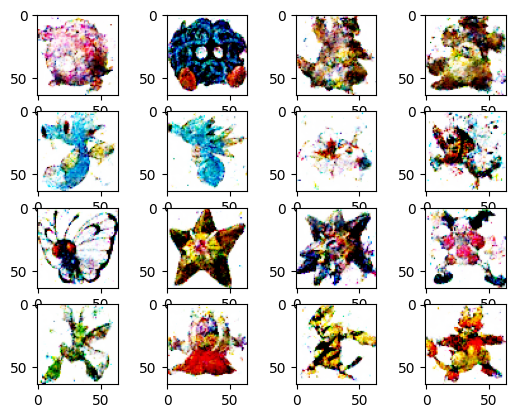

In [47]:
for x in range(0,16):
    image1 = Images[x+16]
    plt.subplot(4,4,x+1)
    image1 = image1.permute(1, 2, 0)
    image1 = image1.to('cpu').detach().numpy()
    plt.imshow(image1)

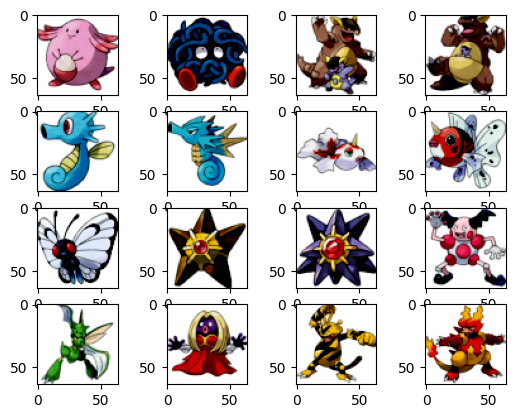

In [48]:
for x in range(0,16):
    image1 = real_images[x+16]
    plt.subplot(4,4,x+1)
    image1 = image1.permute(1, 2, 0)
    image1 = image1.to('cpu').detach().numpy()
    plt.imshow(image1)

In [38]:
class Stage2Generator(nn.Module):
    def __init__(self, text_embedding_dim, img_size):
        super(Stage2Generator, self).__init__()
        self.fc1 = nn.Linear(text_embedding_dim + 3 * img_size * img_size, 128 * 16 * 16)
        self.bn1 = nn.BatchNorm1d(128 * 16 * 16)
        self.relu = nn.ReLU(inplace=True)
        self.upsample1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.upsample2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.upsample3 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1)
        self.tanh = nn.Tanh()
        self.augment  = ConditionalAugmentation(768,768)
        self.img_size = img_size

    def forward(self, text_embedding, stage1_img):
        stage1_img_flat = stage1_img.view(stage1_img.size(0), -1)
        text_embedding = self.augment(text_embedding)
        x = torch.cat((text_embedding, stage1_img_flat), dim=1)
        x = self.relu(self.bn1(self.fc1(x)))
        x = x.view(-1, 128, 16, 16)
        x = self.relu(self.bn2(self.upsample1(x)))
        x = self.relu(self.bn3(self.upsample2(x)))
        x = self.tanh(self.upsample3(x))
        return x

class Stage2Discriminator(nn.Module):
    def __init__(self, img_size):
        super(Stage2Discriminator, self).__init__()
        self.img_encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.text_proj = nn.Linear(768, 512)
        self.classifier = nn.Sequential(
            nn.Conv2d(1024, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, img, text_embedding):
        img_features = self.img_encoder(img)
        text_features = self.text_proj(text_embedding)
        text_features = text_features.view(-1, 512, 1, 1)
        text_features = text_features.repeat(1, 1, img_features.size(2), img_features.size(3))
        features = torch.cat([img_features, text_features], dim=1)
        out = self.classifier(features)
        
        # Average over the spatial dimensions
        out = out.view(out.size(0), -1).mean(dim=1, keepdim=True)
        return out
    
stage2_generator = Stage2Generator(text_embedding_dim=768, img_size=64).to(device)
stage2_discriminator = Stage2Discriminator(img_size=64).to(device)
optimizer_g2 = optim.Adam(stage2_generator.parameters(), lr=0.002, betas=(0.5, 0.999))
optimizer_d2 = optim.Adam(stage2_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [39]:
num_epochs_stage2 = 20
train_stage2(stage2_generator, stage2_discriminator, real_images,text_embeddings, stage1_generator, num_epochs_stage2, device, criterion, optimizer_g2, optimizer_d2)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.59 GiB. GPU 0 has a total capacty of 15.89 GiB of which 1.23 GiB is free. Process 2751 has 14.67 GiB memory in use. Of the allocated memory 13.76 GiB is allocated by PyTorch, and 602.76 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [34]:
Images_stage2 = stage2_generator(text_embeddings,Images)

In [35]:
Images_stage2.shape

torch.Size([833, 3, 128, 128])

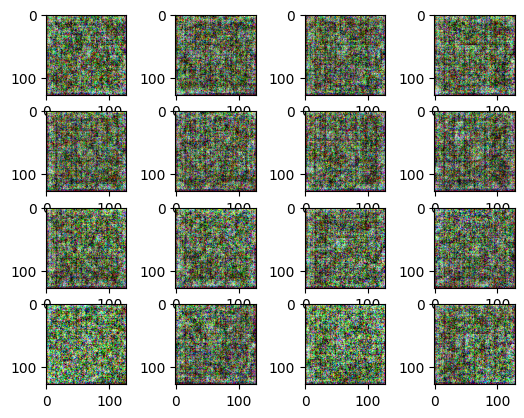

In [36]:
for x in range(0,16):
    image1 = Images_stage2[x]
    plt.subplot(4,4,x+1)
    image1 = image1.permute(1, 2, 0)
    image1 = image1.to('cpu').detach().numpy()
#     plt.axis('false')
    plt.imshow(image1)